# Figure 5: Extending the treatment model to different dose levels between 0 and 100 $\mu$M

In [15]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, residual_multipleTxConditions, ComputeRSquared, \
                            PlotFit, PlotData, LoadFit, \
                            perform_bootstrap, compute_confidenceInterval_prediction, \
                            benchmark_prediction_accuracy, compute_confidenceInterval_parameters

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [16]:
# Data and solver configurations
dataDir = "./data/"
cellLine = "OVCAR3"
runFitting = True
n_bootstraps = 250 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':2}
# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 0.5

# Set up Model 5
modelName = "CycleArrestModel_singleStep_extraDivs_dr"
# Load parameter of the treatment model under 100uM treatment
treatmentModel = "CycleArrestModel_singleStep_extraDivs"
fitObj,_ = LoadFit(treatmentModel,fitDir=os.path.join("./fits/treatmentModel/%s"%cellLine,treatmentModel))
params = fitObj.params
params['phi'].set(vary=False)
params['d_A'].set(vary=False)
params['alpha'].set(vary=False)
treatmentModelBootstrapsDf = pd.read_csv(os.path.join("./fits/treatmentModel", cellLine, treatmentModel, "bootstraps.csv"), index_col=0)

# Add parameters for the non-linear dose response part of Model 5
params.add('n', value=1, min=0, max=10, vary=True)
params.add('EC50', value=42, min=0, max=100, vary=True)

# Environment
modelDir = "./fits/"
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)
utils.mkdir(currOutDir);
nProcesses = 4 # Number of cores to use for bootstrapping
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}

In [17]:
# Load data for 0-50uM
dataDf_DRAssay = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv", index_col=0)
dataDf_DRAssay.rename(columns={"DrugDose":"DrugConcentration"}, inplace=True)
dataDf_DRAssay = dataDf_DRAssay[(dataDf_DRAssay.CellLine==cellLine) & 
                                (dataDf_DRAssay.SeedingDensity=="lowDensity") &
                                (dataDf_DRAssay.CollectionFrequency==3) &
                                (np.isin(dataDf_DRAssay.DrugConcentration,[0, 1, 10, 25, 50]))]

# Load data for 100uM (this is the one we used in fig4, which comes from a different experiment)
drDataDf_100uM = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
drDataDf_100uM = drDataDf_100uM[(drDataDf_100uM.DMax==100) & (drDataDf_100uM.CellLine==cellLine) & 
                                (drDataDf_100uM.Delay==100)]
drDataDf_100uM.rename(columns={"DrugDose":"DrugConcentration"}, inplace=True)

# Take average across replicates when fitting data
drDataDf_full = pd.concat([dataDf_DRAssay, drDataDf_100uM], join="inner")
drDataDf_avg = drDataDf_full.groupby(by=["Time","DrugConcentration"]).mean()
drDataDf_avg.reset_index(inplace=True)

/var/folders/69/cx1jxdf9171bhc7x5sbjn0xh0000gn/T/ipykernel_74860/1155672590.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  drDataDf_avg = drDataDf_full.groupby(by=["Time","DrugConcentration"]).mean()


## b) Map out empirical dose-effect relationship

### "Measure" dose-effect curve by fitting to each dose level keeping all parameters but $\alpha$ fixed

In [7]:
modelName = "CycleArrestModel_singleStep_extraDivs"

for currDose in drDataDf_full['DrugConcentration'].unique():
    currDataDf = drDataDf_avg[drDataDf_avg.DrugConcentration==currDose].copy()
    # The idea is that for each drug dose we compute the value of the drug effect (alpha*D)
    # that gives us the best model fit with Model 4. To do so, we will fix D in the equation and allow just alpha
    # to vary, so that alpha effectively becomes one single "compound" parameter capturing how much 
    # the cell population is impacted by (at that drug level).
    currDataDf['DrugConcentration'] = 100 
    
    # Set phi and d_A in the DE model to the value inferred at 100uM (see jnb_figure4.ipynb for how these are estimated).
    fitObj,_ = LoadFit(modelName,
                       fitDir=os.path.join(modelDir, "treatmentModel", cellLine, modelName))
    params_dr = fitObj.params
    params_dr['phi'].set(vary=False)
    params_dr['d_A'].set(vary=False)
    params_dr['alpha'].set(min=0, max=1, vary=True)
    params_dr['P0'].value = currDataDf.Confluence.iloc[0]
    
    # Setup env
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "mapDR", "trainingDose_%d"%currDose)
    utils.mkdir(currOutDir)
    tmpModel = MakeModelFromStr(modelName)

    # Fit
    fitId = 0
    fitObj = minimize(residual, params_dr, args=(0, currDataDf, tmpModel, "Confluence", solver_kws),**optimiser_kws)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir, "fitObj_fit_%d.p"%(fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0031e+04                                    3.54e+03    
       1              2         7.0621e+02      9.33e+03       5.87e-01       1.51e+03    
       2              3         1.8517e+02      5.21e+02       5.15e-02       3.79e+02    
       3              4         5.1369e+01      1.34e+02       2.79e-02       9.35e+01    
       4              5         1.7418e+01      3.40e+01       1.47e-02       2.31e+01    
       5              6         8.8741e+00      8.54e+00       7.55e-03       5.75e+00    
       6              7         6.7265e+00      2.15e+00       3.83e-03       1.44e+00    
       7              8         6.1850e+00      5.41e-01       1.93e-03       3.38e-01    
       8              9         6.0537e+00      1.31e-01       9.22e-04       9.85e-02    
       9             10         6.0156e+00      3.81e-02       5.08e-04       2.47e-02    

### Plot fits to check this worked correctly

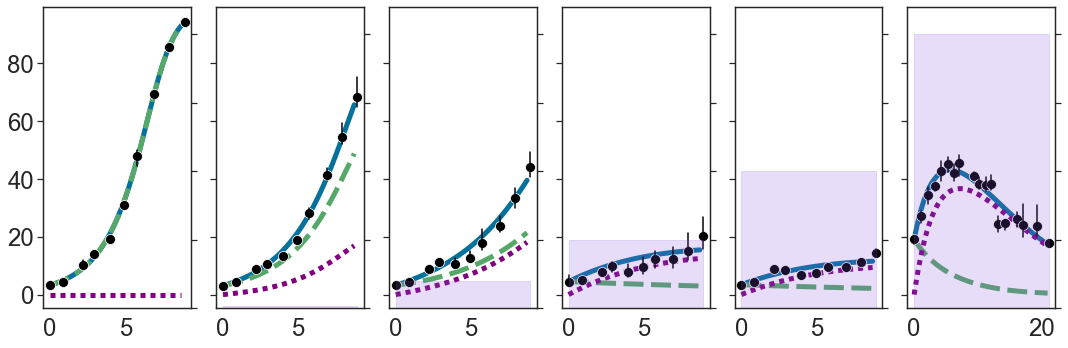

In [8]:
# fig, axList = plt.subplots(2,3,sharex=True,sharey=False,figsize=(11,7))
fig, axList = plt.subplots(1,6,sharex=False,sharey=True,figsize=(15,5))
for i,currDose in enumerate(drDataDf_avg['DrugConcentration'].unique()):
    ax = axList.flatten()[i]
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "mapDR", "trainingDose_%d"%currDose)
    fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
    currDataDf = drDataDf_full[drDataDf_full.DrugConcentration==currDose].copy()

    # Plot the fit
    myModel.paramDic['P0'] = currDataDf.Confluence[currDataDf.Time==0].mean()
    currDataDf['DrugConcentration'] = 100
    myModel.Simulate(treatmentScheduleList=utils.ExtractTreatmentFromDf(currDataDf),**solver_kws)
    myModel.Trim(dt=.25)
    modelFitsDf = pd.melt(myModel.resultsDf, id_vars=['Time'], value_vars=["TumourSize",'P','A'])
    sns.lineplot(x="Time",y="value", hue="variable", style="variable",
             lw=5,palette=cycleArrestModelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
    
    # Plot the data
    sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
             markers="o", lw=0, markersize=10, color="black",
             legend=False,data=currDataDf,ax=ax)
    currDataDf['DrugConcentration'] = currDose
    currDataDf.Confluence = np.nan
    PlotData(currDataDf, y2lim=110, ax=ax)
    ax.tick_params(labelsize=24)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
# plt.savefig("./figures/fits_mapDoseEffect_%s.pdf"%(cellLine))

### Analyse inferred parameters to extract dose-response relationship

In [9]:
tmpList = []
for currDose in drDataDf_avg['DrugConcentration'].unique():
    currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, "mapDR", "trainingDose_%d"%currDose)
    fitObj,_ = LoadFit(modelName, fitDir=currOutDir)
    tmpList.append({"Dose":currDose,
                    "alpha":fitObj.params['alpha'].value,
                    "phi":fitObj.params['phi'].value,
                    "d_A":fitObj.params['d_A'].value})
paramsDf = pd.DataFrame(tmpList)
paramsDf['DrugEffect'] = paramsDf.alpha
paramsDf['DataType'] = "Data"

In [10]:
paramsDf

,Dose,alpha,phi,d_A,DrugEffect,DataType
0,0.0,6.083116e-11,1.422331,0.109165,6.083116e-11,Data
1,1.0,1.438549e-01,1.422331,0.109165,1.438549e-01,Data
2,10.0,2.639245e-01,1.422331,0.109165,2.639245e-01,Data
3,25.0,5.507256e-01,1.422331,0.109165,5.507256e-01,Data
4,50.0,5.557143e-01,1.422331,0.109165,5.557143e-01,Data
5,100.0,6.961626e-01,1.422331,0.109165,6.961626e-01,Data


### Compute dose-response relationship predicted by the linear model (Models 4) and the non-linear Model (Model 5)

**Note**: need to have run model fitting of Model 5 in Section d) of this notebook before this works

In [11]:
def drCurve(D,EMax,EC50,n):
    return EMax*np.power(D,n)/(np.power(EC50, n) + np.power(D, n))

In [12]:
dVec = np.linspace(0,100,100)
modelsToPlotList = ["CycleArrestModel_singleStep_extraDivs", "CycleArrestModel_singleStep_extraDivs_dr"]

tmpList = []
for modelId,modelName in enumerate(modelsToPlotList):
    fitObj,_ = LoadFit(modelName, fitDir=os.path.join(modelDir, "treatmentModel", cellLine, modelName))
    if modelName=="CycleArrestModel_singleStep_extraDivs":
        drugEffect = fitObj.params['alpha'].value*dVec/100
    else:
        drugEffect = drCurve(dVec,EMax=fitObj.params['alpha'].value,
                             EC50=fitObj.params['EC50'].value,
                             n=fitObj.params['n'].value)
    tmpList.append(pd.DataFrame({"Dose":dVec,
                                 "DrugEffect":drugEffect,
                                 "ModelId":modelId+4}))
drCurvesDf = pd.concat(tmpList)

### Plot observed relationship between the drug effect ($\alpha D$) and dose

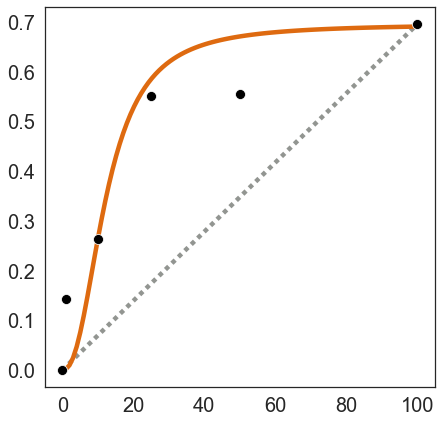

In [13]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x="Dose",y="DrugEffect",style="ModelId",hue="ModelId",
             lw=4.5, palette={4:sns.xkcd_rgb["grey"],5:"#DE6A10"},
             style_order=[5,0,4],
             data=drCurvesDf, ax=ax)
sns.lineplot(x="Dose",y="DrugEffect",style="DataType",
             markers="o", lw=0, markersize=10, color="black",
             legend=False,
             data=paramsDf)
ax.tick_params(labelsize=20)
ax.set_xlabel("")
ax.set_ylabel("")
plt.legend().remove()
plt.savefig("./figures/doseEffectMapping_%s.pdf"%(cellLine))

## d) Fit a model with a non-linear dose-response relationship (Model 5)

In [4]:
modelName = "CycleArrestModel_singleStep_extraDivs_dr"
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)

# Prepare training data
doseToTrainList = [10,50,100]
trainingDataDf_full = drDataDf_full[(np.isin(drDataDf_full.DrugConcentration, doseToTrainList))]
trainingDataDf_avg = drDataDf_avg[(np.isin(drDataDf_avg.DrugConcentration, doseToTrainList))].copy()
trainingDataDf_avg.sort_values(by=["DrugConcentration","Time"], inplace=True)

### Carry out fitting

In [15]:
if runFitting:
    # Setup env
    tmpModel = MakeModelFromStr(modelName)
    currParams = Parameters()
    currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
    if currParams['P0'].vary==False: currParams['P0'].value = trainingDataDf_avg.Confluence.iloc[0]    

    # Fit
    fitObj = minimize(residual_multipleTxConditions, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
    fitObj.fitId = 0
    fitObj.modelName = modelName
    fitObj.data = trainingDataDf_avg
    fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1835e+04                                    9.67e+04    
       1              2         1.5878e+03      1.02e+04       1.80e+01       4.92e+03    
       2              3         2.6066e+02      1.33e+03       8.94e+00       2.95e+03    
       3              4         1.4149e+02      1.19e+02       2.29e+00       7.15e+02    
       4              5         1.2932e+02      1.22e+01       4.59e-01       2.12e+02    
       5              6         1.2859e+02      7.35e-01       2.35e-01       7.54e+01    
       6              7         1.2858e+02      5.20e-03       7.70e-03       1.63e-01    
       7              8         1.2858e+02      2.19e-05       2.26e-03       7.24e-02    
       8              9         1.2858e+02      1.59e-06       5.52e-04       1.90e-02    
       9             10         1.2858e+02      3.94e-08       1.24e-04       1.26e-02    

In [16]:
fitObj

### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [17]:
if runFitting:
    # Turn off verboseness for bootstrapping
    optimiser_kws_bootstrapping = optimiser_kws.copy()
    optimiser_kws_bootstrapping['verbose'] = 0
    # Run bootstrapping
    perform_bootstrap(fitObj=LoadFit(modelName,fitDir=currOutDir)[0],
                      prior_experiment_df=treatmentModelBootstrapsDf,
                      residual_fun=residual_multipleTxConditions,
                      n_conditions=3,
                      n_bootstraps=n_bootstraps, show_progress=True,
                      solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                      outName=os.path.join(currOutDir, "bootstraps.csv"))

100%|██████████| 250/250 [03:51<00:00,  1.08it/s]


### Plot the fits

In [18]:
dosesToPlotList = [0, 10, 50, 100]

# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

tmpDfList = []
for dose in dosesToPlotList:
    currDataDf = drDataDf_avg[drDataDf_avg.DrugConcentration==dose]
    modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(currDataDf),
                                                         initialConditionsList={"P0":currDataDf.Confluence.iloc[0], "A0":0},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)
    modelFitsDf['Dose'] = dose
    tmpDfList.append(modelFitsDf)
modelFitsDf = pd.concat(tmpDfList)

100%|██████████| 250/250 [00:05<00:00, 46.25it/s]


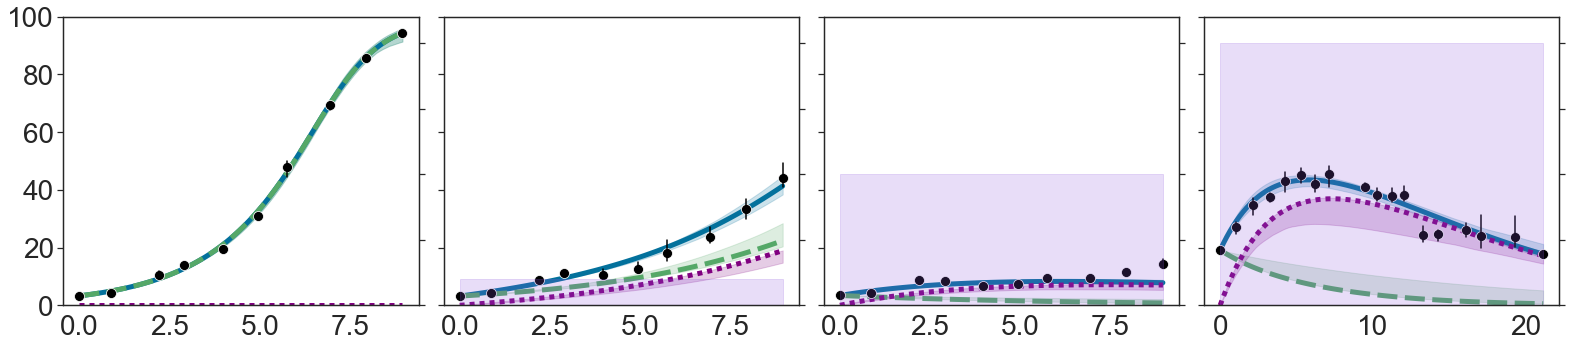

In [19]:
# Plot
fig, axList = plt.subplots(1,len(dosesToPlotList),sharex=False,sharey=True,figsize=(22,5))
for i,dose in enumerate(dosesToPlotList):
    ax = axList[i]
    currModelFitsDf = modelFitsDf[modelFitsDf.Dose==dose]
    # 1. Plot the model predictions and associated confidence intervals
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=cycleArrestModelPalette,
                 legend=False,
                 data=currModelFitsDf, ax=ax)
    for var in cycleArrestModelPalette.keys():
        currDataDf = currModelFitsDf[currModelFitsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=drDataDf_full[drDataDf_full.DrugConcentration==dose], ax=ax)
    # 3. Plot the drug concentration
    tmpDf = drDataDf_avg[drDataDf_avg.DrugConcentration==dose].copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_ylim(0,100)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/fits_model5_%s.pdf"%cellLine)

In [8]:
# Print the number of independent data points for each parameter set
dosesToPlotList = [0, 10, 50, 100]
for i,dose in enumerate(dosesToPlotList):
    tmpDf = drDataDf_avg[drDataDf_avg.DrugConcentration==dose].copy()
    print(tmpDf.shape[0])

10
10
10
18


## e) Model validation using data from various different treatment conditions

In [20]:
modelName = "CycleArrestModel_singleStep_extraDivs_dr"
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)

### Set 1: Continuous treatment starting from low seeding density

In [21]:
doseToTestList = [1, 25, 100]
# Prepare testing data. Here, we will use the 100uM data we collected during the 9d dose response experiment
# as an independent test set (at least in the sense that it was collected during a different round of the 
# experiments).
testingDataDf_full = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv", index_col=0)
testingDataDf_full.rename(columns={"DrugDose":"DrugConcentration"}, inplace=True)
testingDataDf_full = testingDataDf_full[(testingDataDf_full.CellLine==cellLine) & 
                                (testingDataDf_full.SeedingDensity=="lowDensity") &
                                (testingDataDf_full.CollectionFrequency==3) &
                                (np.isin(testingDataDf_full.DrugConcentration, doseToTestList))]
testingDataDf_avg = testingDataDf_full.groupby(by=["Time","DrugConcentration"]).mean()
testingDataDf_avg.reset_index(inplace=True)
testingDataDf_avg.sort_values(by=["DrugConcentration","Time"], inplace=True)

In [22]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

tmpDfList = []
for dose in doseToTestList:
    currDataDf = testingDataDf_avg[testingDataDf_avg.DrugConcentration==dose]
    modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(currDataDf),
                                                         initialConditionsList={"P0":currDataDf.Confluence.iloc[0], "A0":0},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)
    modelPredictionsDf['Dose'] = dose
    tmpDfList.append(modelPredictionsDf)
modelPredictionsDf = pd.concat(tmpDfList)

100%|██████████| 250/250 [00:02<00:00, 89.95it/s]


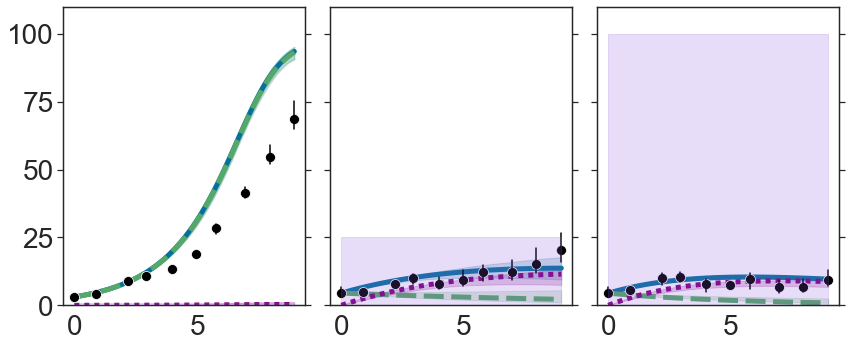

In [23]:
# Plot
fig, axList = plt.subplots(1,len(doseToTestList),sharex=False,sharey=True,figsize=(12,5))
for i,dose in enumerate(doseToTestList):
    ax = axList[i]
    currModelPredictionsDf = modelPredictionsDf[modelPredictionsDf.Dose==dose]
    # 1. Plot the model predictions and associated confidence intervals
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=cycleArrestModelPalette,
                 legend=False,
                 data=currModelPredictionsDf, ax=ax)
    for var in cycleArrestModelPalette.keys():
        currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=testingDataDf_full[testingDataDf_full.DrugConcentration==dose], ax=ax)
    # 3. Plot the drug concentration
    tmpDf = testingDataDf_avg[testingDataDf_avg.DrugConcentration==dose].copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_ylim(0,110)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/predictions_model5_lowDensity_%s.pdf"%cellLine)

### Set 2: Continuous treatment starting from high seeding density

In [24]:
doseToTestList = [1, 25, 100]
# Prepare testing data
testingDataDf_full = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv", index_col=0)
testingDataDf_full.rename(columns={"DrugDose":"DrugConcentration"}, inplace=True)
testingDataDf_full = testingDataDf_full[(testingDataDf_full.CellLine==cellLine) & 
                                (testingDataDf_full.SeedingDensity=="highDensity") &
                                (testingDataDf_full.CollectionFrequency==3) &
                                (np.isin(testingDataDf_full.DrugConcentration, doseToTestList))]
testingDataDf_avg = testingDataDf_full.groupby(by=["Time","DrugConcentration"]).mean()
testingDataDf_avg.reset_index(inplace=True)
testingDataDf_avg.sort_values(by=["DrugConcentration","Time"], inplace=True)

In [25]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

tmpDfList = []
for dose in doseToTestList:
    currDataDf = testingDataDf_avg[testingDataDf_avg.DrugConcentration==dose]
    modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(currDataDf),
                                                         initialConditionsList={"P0":currDataDf.Confluence.iloc[0], "A0":0},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)
    modelPredictionsDf['Dose'] = dose
    tmpDfList.append(modelPredictionsDf)
modelPredictionsDf = pd.concat(tmpDfList)

100%|██████████| 250/250 [00:02<00:00, 87.45it/s]


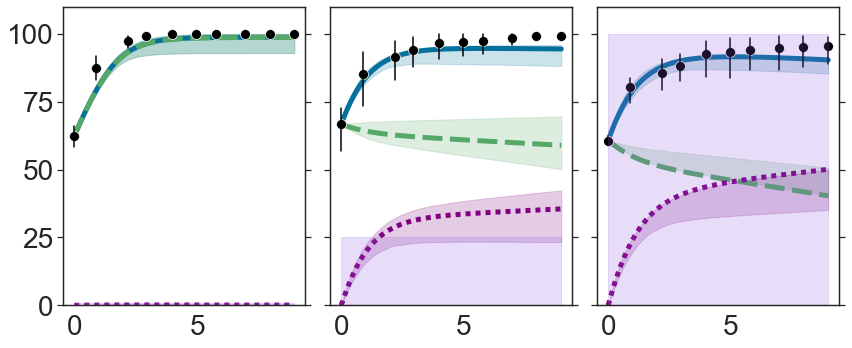

In [26]:
# Plot
fig, axList = plt.subplots(1,len(doseToTestList),sharex=False,sharey=True,figsize=(12,5))
for i,dose in enumerate(doseToTestList):
    ax = axList[i]
    currModelPredictionsDf = modelPredictionsDf[modelPredictionsDf.Dose==dose]
    # 1. Plot the model predictions and associated confidence intervals
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=cycleArrestModelPalette,
                 legend=False,
                 data=currModelPredictionsDf, ax=ax)
    for var in cycleArrestModelPalette.keys():
        currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=testingDataDf_full[testingDataDf_full.DrugConcentration==dose], ax=ax)
    # 3. Plot the drug concentration
    tmpDf = testingDataDf_avg[testingDataDf_avg.DrugConcentration==dose].copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_ylim(0,110)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/predictions_model5_highDensity_%s.pdf"%cellLine)

### Set 3: On/Off treatment with 50uM

In [27]:
conditionsToTestList = [2, 4, 7]

# Prepare testing data
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==50) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model
testingDataDf_full = dataDf_all[np.isin(dataDf_all.Delay, [conditionsToTestList])]
testingDataDf_avg = testingDataDf_full.groupby(by=["Time","Delay"]).mean().reset_index()

In [28]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

tmpDfList = []
for timeOnTreatment in conditionsToTestList:
    currDataDf = testingDataDf_avg[testingDataDf_avg.Delay==timeOnTreatment]
    modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(currDataDf),
                                                         initialConditionsList={"P0":currDataDf.Confluence.iloc[0], "A0":0},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)
    modelPredictionsDf['TimeOnTreatment'] = timeOnTreatment
    tmpDfList.append(modelPredictionsDf)
modelPredictionsDf = pd.concat(tmpDfList)

100%|██████████| 250/250 [00:05<00:00, 44.17it/s]


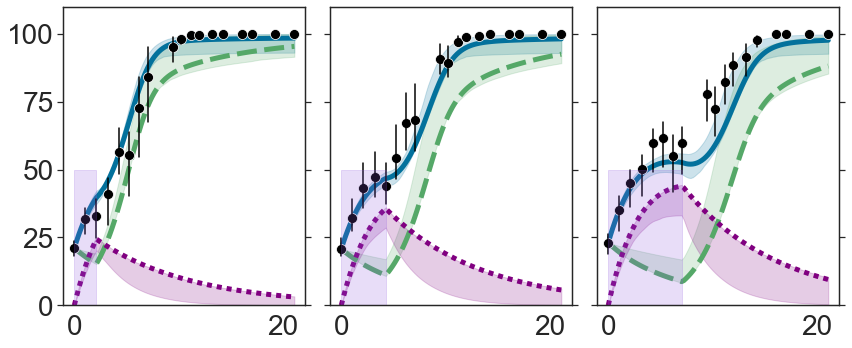

In [29]:
# Plot
fig, axList = plt.subplots(1,len(doseToTestList),sharex=False,sharey=True,figsize=(12,5))
for i,timeOnTreatment in enumerate(conditionsToTestList):
    ax = axList[i]
    currModelPredictionsDf = modelPredictionsDf[modelPredictionsDf.TimeOnTreatment==timeOnTreatment]
    # 1. Plot the model predictions and associated confidence intervals
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=cycleArrestModelPalette,
                 legend=False,
                 data=currModelPredictionsDf, ax=ax)
    for var in cycleArrestModelPalette.keys():
        currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=testingDataDf_full[testingDataDf_full.Delay==timeOnTreatment], ax=ax)
    # 3. Plot the drug concentration
    tmpDf = testingDataDf_avg[testingDataDf_avg.Delay==timeOnTreatment].copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_ylim(0,110)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/predictions_model5_imt50_%s.pdf"%cellLine)

### Set 4: On/Off treatment with 100uM

In [30]:
conditionsToTestList = [2, 4, 7]

# Prepare testing data
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model
testingDataDf_full = dataDf_all[np.isin(dataDf_all.Delay, [conditionsToTestList])]
testingDataDf_avg = testingDataDf_full.groupby(by=["Time","Delay"]).mean().reset_index()

In [31]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

tmpDfList = []
for timeOnTreatment in conditionsToTestList:
    currDataDf = testingDataDf_avg[testingDataDf_avg.Delay==timeOnTreatment]
    modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                         treatmentScheduleList=utils.ExtractTreatmentFromDf(currDataDf),
                                                         initialConditionsList={"P0":currDataDf.Confluence.iloc[0], "A0":0},
                                                         show_progress=True, n_time_steps=100,
                                                         alpha=ci_significanceLevel,
                                                         solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)
    modelPredictionsDf['TimeOnTreatment'] = timeOnTreatment
    tmpDfList.append(modelPredictionsDf)
modelPredictionsDf = pd.concat(tmpDfList)

100%|██████████| 250/250 [00:05<00:00, 43.93it/s]


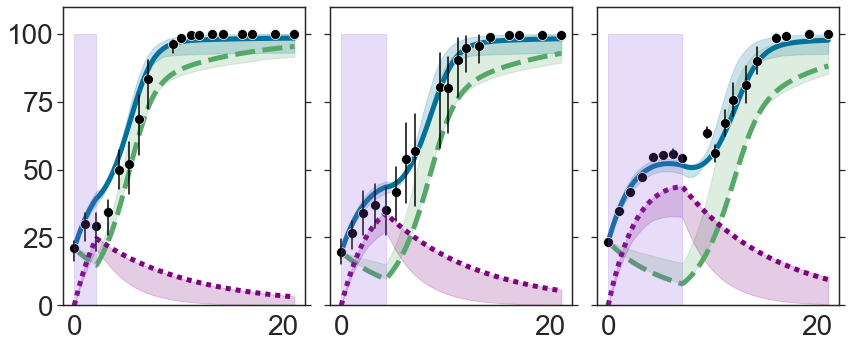

In [32]:
# Plot
fig, axList = plt.subplots(1,len(doseToTestList),sharex=False,sharey=True,figsize=(12,5))
for i,timeOnTreatment in enumerate(conditionsToTestList):
    ax = axList[i]
    currModelPredictionsDf = modelPredictionsDf[modelPredictionsDf.TimeOnTreatment==timeOnTreatment]
    # 1. Plot the model predictions and associated confidence intervals
    sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                 lw=5, palette=cycleArrestModelPalette,
                 legend=False,
                 data=currModelPredictionsDf, ax=ax)
    for var in cycleArrestModelPalette.keys():
        currDataDf = currModelPredictionsDf[currModelPredictionsDf.Variable==var]
        ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                         currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
    # 2. Plot the data
    sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
                 markers="o", lw=0, markersize=10, color="black",
                 legend=False, data=testingDataDf_full[testingDataDf_full.Delay==timeOnTreatment], ax=ax)
    # 3. Plot the drug concentration
    tmpDf = testingDataDf_avg[testingDataDf_avg.Delay==timeOnTreatment].copy()
    tmpDf.Confluence = np.nan
    PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_ylim(0,110)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/predictions_model5_imt100_%s.pdf"%cellLine)